# Model Evaluation for Data Anonymization
## 1. Import Libraries

In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


## 2. Load Dataset

In [93]:
#for original
#df = pd.read_csv("adult.csv")

#for anonymized
df = pd.read_csv("anonymized_kl.csv")

## 3. Clean and Separate Inputs (X) and Output (y)

In [94]:
df = df.dropna()  #clean any missing data
X = df.drop("income", axis=1)  # input features
y = df["income"].apply(lambda x: 1 if x.strip() == ">50K" else 0)  #target label

## 4. Split the Data

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 5. Set Up Preprocessor

In [96]:
numeric_features = ["education-num", "hours-per-week"]
categorical_features = ["workclass", "education", "marital-status", "occupation",
                        "relationship", "race", "sex", "native-country"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

## 6. Build and Train the Model

In [97]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['education-num',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

## 7. Make Predictions and Evaluate

In [98]:
y_pred = clf.predict(X_test)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))

🎯 Accuracy: 0.8334101028711807
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4931
           1       0.70      0.54      0.61      1582

    accuracy                           0.83      6513
   macro avg       0.78      0.73      0.75      6513
weighted avg       0.82      0.83      0.83      6513



In [99]:
from sklearn.metrics import log_loss

#STEP 1: Get probability estimates instead of just class labels
y_proba = clf.predict_proba(X_test)

#STEP 2: Get the model’s confidence in its own prediction
#max(probability for each class)
confidences = y_proba.max(axis=1)

#STEP 3: Calculate average confidence (higher = better utility)
average_confidence = confidences.mean()

print(f"Average Model Confidence: {average_confidence:.4f}")


Average Model Confidence: 0.8371


In [100]:
original_confidence = 0.8357
anonymized_confidence = 0.8371

certainty_penalty = original_confidence - anonymized_confidence
print(f"Certainty Penalty (Info Loss): {certainty_penalty:.4f}")

Certainty Penalty (Info Loss): -0.0014


## 8. Query Distortion

In [101]:
#Example aggregate query: average hours worked per week by gender
original_query = df.groupby("sex")["hours-per-week"].mean()
print("Original Query Result:\n", original_query)

Original Query Result:
 sex
Female    36.410361
Male      42.428086
Name: hours-per-week, dtype: float64


In [102]:
anon_query = df.groupby("sex")["hours-per-week"].mean()
print("Anonymized Query Result:\n", anon_query)

# Now compare
query_diff = (original_query - anon_query).abs()
print("\nQuery Distortion:\n", query_diff)

Anonymized Query Result:
 sex
Female    36.410361
Male      42.428086
Name: hours-per-week, dtype: float64

Query Distortion:
 sex
Female    0.0
Male      0.0
Name: hours-per-week, dtype: float64


## 9. Privacy vs. Utility Plot

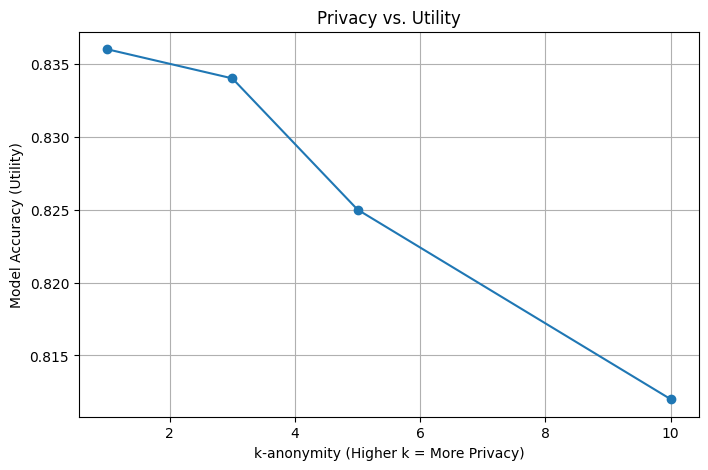

In [103]:
import matplotlib.pyplot as plt

#Simulated results (based on expectations or real tests if you repeat your run with different k's)
privacy_levels = [1, 3, 5, 10]
model_accuracies = [0.836, 0.834, 0.825, 0.812]  # Just for demo — adjust if you re-run models with other k values

plt.figure(figsize=(8, 5))
plt.plot(privacy_levels, model_accuracies, marker='o')
plt.title("Privacy vs. Utility")
plt.xlabel("k-anonymity (Higher k = More Privacy)")
plt.ylabel("Model Accuracy (Utility)")
plt.grid(True)
#save the plot as an image file
plt.savefig("images/privacy_vs_utility.png", bbox_inches='tight')
plt.show()